In [1]:
%load_ext autoreload
%autoreload 2

import sys; print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['C:\\Users\\troy\\Documents\\Code\\Libraries', 'C:\\Users\\troy\\Documents\\Excel Sheets', 'C:/Users/troy/Documents/Code/Libraries'])
from datetime import date, datetime, timedelta
import numpy as np
import pandas as pd
import ipywidgets as widgets
import matplotlib.pyplot as plt

import dash_bootstrap_components as dbc
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
import dash_table
from dash.dependencies import Input, Output

from tia.bbg import LocalTerminal

from FinAPI import black_lognormal, black_lognormal_vol, black_delta, black_lognormal_greek

Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)] on win32


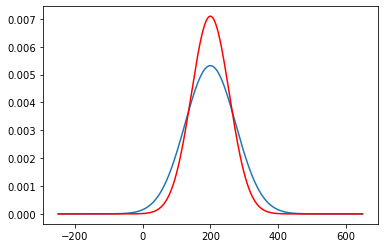

In [11]:
sigma = 150
time_to_expiry = 0.25

dist_vol = sigma * np.sqrt(time_to_expiry)
fwd = 200

x = np.linspace(200 -6 * dist_vol, 200 + 6 * dist_vol, 500)
density = 1 / (dist_vol * np.sqrt(2 * np.pi )) * np.exp(-0.5*((x - fwd)/dist_vol)**2)

scale = 0.75
density2 = 1 / (scale*dist_vol * np.sqrt(2 * np.pi )) * np.exp(-0.5*((x - fwd)/(scale*dist_vol))**2)

plt.plot(x, density)
plt.plot(x, density2, color='red')


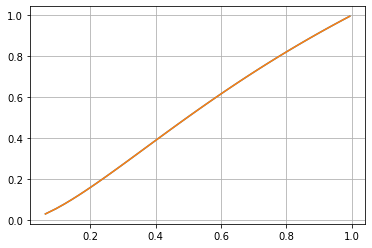

In [34]:
from scipy.optimize import root_scalar

def dist_decay(x, scale, fwd, dist_vol):
    orig_dist = 1 / (dist_vol * np.sqrt(2 * np.pi )) * np.exp(-0.5*((x - fwd)/dist_vol)**2)
    new_dist = 1 / (scale*dist_vol * np.sqrt(2 * np.pi )) * np.exp(-0.5*((x - fwd)/(scale*dist_vol))**2)
    diff = new_dist - orig_dist
    return diff

def compute_positive_decay_interval(scale, init_vol, fwd):
    dist_vol = init_vol
    sol_low = root_scalar(dist_decay, args=(scale, fwd, dist_vol), method='bisect', bracket=[fwd - 10*dist_vol, fwd])
    sol_upper = root_scalar(dist_decay, args=(scale, fwd, dist_vol), method='bisect', bracket=[fwd, fwd + 10*dist_vol])

    l = sol_low.root
    u = sol_upper.root

    return dict(abs_l=l, abs_u=u, norm_l = (l - fwd)/dist_vol, norm_u = (u - fwd) / dist_vol)

def plot_norm_u_vs_scale(init_vol, fwd, ax=None, x_transform=None, y_transform=None):
    scales = np.linspace(0.01, 0.99, 100)
    norm_uppers = [compute_positive_decay_interval(s, init_vol, fwd)['norm_u'] for s in scales]
    if ax is None:
        fig, ax = plt.subplots()
    if x_transform is not None:
        scale_x = x_transform(scales)
    else:
        scale_x = scales
    if y_transform is not None:
        scale_norm_upper = y_transform(norm_uppers)
    else:
        scale_norm_upper = norm_uppers

    ax.plot(scale_x, scale_norm_upper)
    return ax

ax = plot_norm_u_vs_scale(dist_vol, fwd, x_transform=lambda x : x**(0.6))
ax.grid()